## Derive an RE24 matrix and LWTS from PBP data

Following the methodology described here: https://library.fangraphs.com/the-beginners-guide-to-deriving-woba/

Basic steps:

1. Compute an RE24 table by grouping all events based on starting base-out state and looking at runs scored from those situations.
2. For each PA, add the starting RE, ending RE, and the change in RE.
3. Group all of that by event type to get an average run value for each event type.
4. Store off a PA data table, which includes RE and run value fields, to use in further analysis.

Now that we have this PA table, there are all sorts of things we could do next:
* Compute wOBA weights
* Aggregate run value or RE along various dimensions (e.g., on batter or pitcher)
* Create a model to predict run value of a particular PA (e.g., based on batter and pitcher stats)

In [1]:
import pandas as pd
import numpy as np
import boxball_loader as bbl

In [74]:
YEARS = range(1996, 2007)
cols = ['game_id', 'fate_runs_ct', 'event_runs_ct', 'outs_ct', 'event_outs_ct', 'start_bases_cd', 
        'inn_ct', 'bat_home_id', 'end_bases_cd', 'game_pa_ct', 'game_end_fl', 'pit_id', 'bat_id', 
        'bat_hand_cd', 'event_cd', 'resp_pit_hand_cd', 'resp_bat_hand_cd'
]


In [75]:
ev = bbl.load_event_data(start_yr=YEARS[0], end_yr=YEARS[-1], requested_columns=cols)


In [76]:
ev.columns

Index(['game_id', 'date', 'bat_hand_cd', 'event_runs_ct', 'resp_pit_hand_cd',
       'inn_ct', 'fate_runs_ct', 'pit_id', 'outs_ct', 'bat_event_fl', 'tb_ct',
       'bat_id', 'resp_bat_hand_cd', 'event_outs_ct', 'end_bases_cd',
       'start_bases_cd', 'event_cd', 'game_end_fl', 'ab_fl', 'bat_home_id',
       'game_pa_ct', 'h_fl', 'ob_fl', 'yr'],
      dtype='object')

In [77]:
# Add a couple columns for computing RE24
ev['runs_finish_ct']=ev.fate_runs_ct+ev.event_runs_ct #total runs in remainder of inning
ev['end_outs_ct']=ev.outs_ct+ev.event_outs_ct # outs at end of event

In [78]:
# Choose which games we want
gms = bbl.load_gamelogs(game_types=bbl.GameType.RS, years=YEARS)

evs = ev[ev.game_id.isin(gms.game_id)]
evs.shape

(2044977, 26)

In [79]:
# Generate a basic RE24 table
re24 = evs.groupby(['start_bases_cd', 'outs_ct'])['runs_finish_ct'].mean().unstack()
re24[3] = re24[2]*0
re24 = re24.unstack()
re24

outs_ct  start_bases_cd
0        0                 0.541776
         1                 0.929614
         2                 1.171198
         3                 1.535974
         4                 1.452969
         5                 1.849558
         6                 2.038084
         7                 2.360133
1        0                 0.290864
         1                 0.560685
         2                 0.709766
         3                 0.950518
         4                 0.984971
         5                 1.207949
         6                 1.429059
         7                 1.604488
2        0                 0.112200
         1                 0.242731
         2                 0.341883
         3                 0.456589
         4                 0.373500
         5                 0.511639
         6                 0.596420
         7                 0.787508
3        0                 0.000000
         1                 0.000000
         2                 0.000000
    

In [80]:
def get_printable_re24table(re24):
    df = re24.reset_index()
    start_bases_txt = df['start_bases_cd'].apply(lambda x: ['___', '1__', '_2_', '12_', '__3', '1_3', '_23', '123'][int(x)])
    df['bases'] = start_bases_txt
    printable = df.rename(columns={0: 'run_exp', 'outs_ct': 'outs'}) \
        .set_index(['outs', 'bases']) \
        .unstack(level=0) \
        .sort_values(by=('start_bases_cd', 0))['run_exp']

    return printable.to_markdown()

print(get_printable_re24table(re24))

| bases   |        0 |        1 |        2 |   3 |
|:--------|---------:|---------:|---------:|----:|
| ___     | 0.541776 | 0.290864 | 0.1122   |   0 |
| 1__     | 0.929614 | 0.560685 | 0.242731 |   0 |
| _2_     | 1.1712   | 0.709766 | 0.341883 |   0 |
| 12_     | 1.53597  | 0.950518 | 0.456589 |   0 |
| __3     | 1.45297  | 0.984971 | 0.3735   |   0 |
| 1_3     | 1.84956  | 1.20795  | 0.511639 |   0 |
| _23     | 2.03808  | 1.42906  | 0.59642  |   0 |
| 123     | 2.36013  | 1.60449  | 0.787508 |   0 |


In [9]:
evs['score_left'] = np.where(evs['runs_finish_ct']>0, 1, 0)
evs.groupby(['start_bases_cd', 'outs_ct'])['score_left'].mean().unstack()

<ipython-input-9-9858b6c33351>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evs['score_left'] = np.where(evs['runs_finish_ct']>0, 1, 0)


outs_ct,0,1,2
start_bases_cd,,,
0,0.278379,0.164974,0.072256
1,0.410378,0.263977,0.123768
2,0.609348,0.394741,0.213446
3,0.611325,0.411095,0.224319
4,0.834448,0.654670,0.247780
5,0.848439,0.636088,0.263286
6,0.837022,0.669411,0.247770
7,0.851392,0.658371,0.310700


In [10]:
gms.shape

(13045, 164)

In [11]:
half_innings = len(evs.groupby(['game_id', 'inn_ct', 'bat_home_id']))
half_innings

233030

In [12]:
# Now compute RE24 for each event
def add_REs_to_events(evs):
    # Add the re_start and re_end to each event (merge is faster than a lookup)
    e_s = pd.merge(left=evs, right=re24.rename('re_start'), on=['start_bases_cd', 'outs_ct'])
    e_e = pd.merge(left=e_s, right=re24.rename('re_end'), \
               left_on=['end_bases_cd', 'end_outs_ct'], \
               right_on=['start_bases_cd', 'outs_ct'])
    e_e['re_added'] = e_e['re_end'] - e_e['re_start'] + e_e['event_runs_ct']
    return e_e.sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])

In [13]:
evs_re = add_REs_to_events(evs)
evs_re.head(20)

,game_id,date,event_outs_ct,resp_bat_hand_cd,event_cd,bat_id,inn_ct,start_bases_cd,bat_home_id,end_bases_cd,...,game_end_fl,h_fl,ob_fl,yr,runs_finish_ct,end_outs_ct,score_left,re_start,re_end,re_added
601,ANA201504100,2015-04-10,1,R,2,escoa003,1,0,False,0,...,False,0,0,2015,1,1,1,0.508991,0.272736,-0.236255
357739,ANA201504100,2015-04-10,1,L,2,mousm001,1,0,False,0,...,False,0,0,2015,1,2,1,0.272736,0.105645,-0.167091
540052,ANA201504100,2015-04-10,0,R,21,cainl001,1,0,False,2,...,False,1,1,2015,1,2,1,0.105645,0.322193,0.216548
582942,ANA201504100,2015-04-10,0,L,20,hosme001,1,2,False,1,...,False,1,1,2015,1,2,1,0.322193,0.228667,0.906473
813264,ANA201504100,2015-04-10,0,R,20,morak001,1,1,False,3,...,False,1,1,2015,0,2,0,0.228667,0.441330,0.212663
953368,ANA201504100,2015-04-10,1,L,2,gorda001,1,3,False,3,...,False,0,0,2015,0,3,0,0.441330,0.000000,-0.441330
602,ANA201504100,2015-04-10,1,L,2,calhk001,1,0,True,0,...,False,0,0,2015,0,1,0,0.508991,0.272736,-0.236255
357740,ANA201504100,2015-04-10,1,R,2,troum001,1,0,True,0,...,False,0,0,2015,0,2,0,0.272736,0.105645,-0.167091
665546,ANA201504100,2015-04-10,1,R,2,pujoa001,1,0,True,0,...,False,0,0,2015,0,3,0,0.105645,0.000000,-0.105645
603,ANA201504100,2015-04-10,1,R,2,riosa002,2,0,False,0,...,False,0,0,2015,0,1,0,0.508991,0.272736,-0.236255


In [14]:
# Just to sanity check, let's compute the sum by pitcher
evs_re.groupby('pit_id')['re_added'].sum().sort_values()

pit_id
kersc001   -218.783645
schem001   -216.991135
degrj001   -208.188286
verlj001   -169.880257
greiz001   -157.997889
               ...    
butle001     56.167744
perem004     57.011216
holld003     57.925114
jacke001     60.164482
zimmj003     71.418402
Name: re_added, Length: 1677, dtype: float64

In [15]:
# What does total re_added sum to?
evs_re.re_added.sum()

-2444.483258913298

We might've expected the sum to come out to zero.  But it doesn't exactly, because RE24[0][0] isn't exactly equal to the the number of runs per inning.  This is because there are other [0][0] occurrences (e.g., after a leadoff HR) that are included in the re24[0][0] calculation.

In [16]:
evs_re[evs_re.game_end_fl].re_end.sum()

702.1824761747374

In [17]:
# Now look at average RE change by event code
# This is the context-neutral run value of each event type
event_res = evs_re.groupby('event_cd').agg({'re_added': np.mean})['re_added'].rename('event_re')
event_res

event_cd
2    -0.271586
3    -0.271045
14    0.309378
15    0.174751
16    0.330713
17    0.357823
18    0.479972
19   -0.133677
20    0.448838
21    0.753802
22    1.041791
23    1.382945
Name: event_re, dtype: float64

In [18]:
# Annotate each event with the context-neutral run value of the event type
evs_re = pd.merge(left=evs_re, right=event_res, on='event_cd') \
    .sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])

evs_re.head(20)

,game_id,date,event_outs_ct,resp_bat_hand_cd,event_cd,bat_id,inn_ct,start_bases_cd,bat_home_id,end_bases_cd,...,h_fl,ob_fl,yr,runs_finish_ct,end_outs_ct,score_left,re_start,re_end,re_added,event_re
0,ANA201504100,2015-04-10,1,R,2,escoa003,1,0,False,0,...,0,0,2015,1,1,1,0.508991,0.272736,-0.236255,-0.271586
1,ANA201504100,2015-04-10,1,L,2,mousm001,1,0,False,0,...,0,0,2015,1,2,1,0.272736,0.105645,-0.167091,-0.271586
447890,ANA201504100,2015-04-10,0,R,21,cainl001,1,0,False,2,...,1,1,2015,1,2,1,0.105645,0.322193,0.216548,0.753802
492401,ANA201504100,2015-04-10,0,L,20,hosme001,1,2,False,1,...,1,1,2015,1,2,1,0.322193,0.228667,0.906473,0.448838
492402,ANA201504100,2015-04-10,0,R,20,morak001,1,1,False,3,...,1,1,2015,0,2,0,0.228667,0.441330,0.212663,0.448838
2,ANA201504100,2015-04-10,1,L,2,gorda001,1,3,False,3,...,0,0,2015,0,3,0,0.441330,0.000000,-0.441330,-0.271586
3,ANA201504100,2015-04-10,1,L,2,calhk001,1,0,True,0,...,0,0,2015,0,1,0,0.508991,0.272736,-0.236255,-0.271586
4,ANA201504100,2015-04-10,1,R,2,troum001,1,0,True,0,...,0,0,2015,0,2,0,0.272736,0.105645,-0.167091,-0.271586
5,ANA201504100,2015-04-10,1,R,2,pujoa001,1,0,True,0,...,0,0,2015,0,3,0,0.105645,0.000000,-0.105645,-0.271586
6,ANA201504100,2015-04-10,1,R,2,riosa002,2,0,False,0,...,0,0,2015,0,1,0,0.508991,0.272736,-0.236255,-0.271586


In [19]:
# Let's repeat the sanity check, let's compute the sum by pitcher
# Should see the context-sensitive and context-neutral match up
evs_re.groupby('pit_id')[['re_added', 'event_re']].sum().sort_values(by='re_added')

,re_added,event_re
pit_id,,
kersc001,-218.783645,-216.507300
schem001,-216.991135,-226.970193
degrj001,-208.188286,-206.699626
verlj001,-169.880257,-189.603570
greiz001,-157.997889,-173.021559
...,...,...
butle001,56.167744,51.848756
perem004,57.011216,60.020888
holld003,57.925114,59.536481


In [20]:
# Now repeat for batters
# Should see the context-sensitive and context-neutral match up
evs_re.groupby('bat_id')[['re_added', 'event_re']].sum().sort_values(by='re_added')

,re_added,event_re
bat_id,,
hamib001,-116.493692,-114.952511
escoa003,-98.762970,-108.990425
maldm001,-72.770067,-63.262213
mathj001,-68.516599,-69.914363
hedga001,-68.019353,-67.837464
...,...,...
bettm001,215.824108,188.996133
arenn001,221.198133,191.472385
freef001,228.197794,206.235182


In [21]:
pa = evs_re
pa.groupby('event_cd').agg({'re_added': np.mean})

,re_added
event_cd,
2,-0.271586
3,-0.271045
14,0.309378
15,0.174751
16,0.330713
17,0.357823
18,0.479972
19,-0.133677
20,0.448838


In [22]:
# We'll start simple: consider only uBB, HBP, 1B, 2B, 3B, HR; ignore IBB and Interference; everything else is an "out"

# First the positives
success_cols = [14, 16, 20, 21, 22, 23]
ignore_cols = [15, 17]
success_weights = pa[pa.event_cd.isin(success_cols)].groupby('event_cd') \
    .agg({'re_added': [len, np.mean]})['re_added'] \
    .rename(columns={'len': 'ct', 'mean': 're_added'})

success_weights

,ct,re_added
event_cd,,
14,77926.0,0.309378
16,9743.0,0.330713
20,143813.0,0.448838
21,44511.0,0.753802
22,4480.0,1.041791
23,31289.0,1.382945


In [23]:
out_weights = pa[~pa.event_cd.isin(success_cols+ignore_cols)] \
    .agg({'re_added': [len, np.mean]}) \
    .rename(columns={'re_added': 'out'}) \
    .T.rename(columns={'len': 'ct', 'mean': 're_added'})
out_weights

,ct,re_added
out,674912.0,-0.261861


In [24]:
weights = pd.concat([success_weights, out_weights])
weights

,ct,re_added
14,77926.0,0.309378
16,9743.0,0.330713
20,143813.0,0.448838
21,44511.0,0.753802
22,4480.0,1.041791
23,31289.0,1.382945
out,674912.0,-0.261861


In [25]:
out_value=out_weights['re_added'][0]
out_value

-0.26186118859664076

In [26]:
weights['re_over_out'] = weights.re_added-out_value
weights

,ct,re_added,re_over_out
14,77926.0,0.309378,0.571239
16,9743.0,0.330713,0.592574
20,143813.0,0.448838,0.710699
21,44511.0,0.753802,1.015663
22,4480.0,1.041791,1.303652
23,31289.0,1.382945,1.644807
out,674912.0,-0.261861,0.000000


In [27]:
raw_woba = sum(weights['ct']*weights['re_over_out'])/sum(weights['ct'])
raw_woba

0.25845260030667655

In [28]:
sum(weights['ct']*weights['re_over_out'])

255008.4609549898

In [29]:
target_woba = .315
woba_scale = target_woba/raw_woba
weights['woba_wt'] = weights['re_over_out']*woba_scale
weights, woba_scale

(           ct  re_added  re_over_out   woba_wt
 14    77926.0  0.309378     0.571239  0.696221
 16     9743.0  0.330713     0.592574  0.722225
 20   143813.0  0.448838     0.710699  0.866194
 21    44511.0  0.753802     1.015663  1.237882
 22     4480.0  1.041791     1.303652  1.588881
 23    31289.0  1.382945     1.644807  2.004677
 out  674912.0 -0.261861     0.000000  0.000000,
 1.2187921484489808)

OK, so that gives us wOBA weights!

In [30]:
def summarize_stats(pa, groupby):
    counters_map = {'bat_event_fl': 'pa', 'ob_fl': 'ob', 'ab_fl': 'ab', 'h_fl': 'h', 'tb_ct': 'tb'}
    groups = pa.groupby(groupby)
    stats = groups[list(counters_map.keys())].sum().rename(columns=counters_map)
    stats['ba'] = stats['h']/stats['ab']
    stats['obp'] = stats['ob']/stats['pa']
    stats['slg'] = stats['tb']/stats['ab']
    woba_weights = {'ob': .702, 'tb': .37, 'h': -.21}
    stats['woba'] = sum([stats[stat]*woba_weights[stat] for stat in woba_weights.keys()])/stats['pa']
    return stats

In [31]:
summarize_stats(pa, ['bat_hand_cd'])

,pa,ob,ab,h,tb,ba,obp,slg,woba
bat_hand_cd,,,,,,,,,
?,1,0,1,0,0.0,0.000000,0.000000,0.000000,0.000000
L,411568,131527,365435,92169,152849.0,0.252217,0.319575,0.418266,0.314725
R,580096,180235,522293,131924,218582.0,0.252586,0.310699,0.418505,0.309770


## Modeling individual PAs

### Measure outcome: run value based on event code
### Batter estimate (wOBA)
### Pitcher estimate (wOBA allowed)
### Regression or other model

In [32]:
batters = pa.groupby('bat_id')['event_re'].mean().rename('bat_re_avg')
batters

bat_id
aardd001   -0.271045
abadf001   -0.271045
abrej003    0.032815
ackld001   -0.036338
acunr001    0.053116
              ...   
zimmb001   -0.027006
zimmj003   -0.161593
zimmr001    0.013927
zobrb001    0.016474
zunim001   -0.029937
Name: bat_re_avg, Length: 1970, dtype: float64

In [33]:
pitchers = pa.groupby('pit_id')['event_re'].mean().rename('pit_re_avg')
pitchers

pit_id
aardd001    0.003467
abadf001   -0.013324
abrea001    0.235788
abreb002   -0.055529
achta001    0.028390
              ...   
zimmk001    0.023866
zitob001    0.194086
zobrb001   -0.039092
zubet001    0.000646
zycht001   -0.035502
Name: pit_re_avg, Length: 1677, dtype: float64

In [34]:
pa = pd.merge(left=pa, right=batters, on='bat_id')
pa = pd.merge(left=pa, right=pitchers, on='pit_id')

In [35]:
pa = pa.sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])
pa

,game_id,date,event_outs_ct,resp_bat_hand_cd,event_cd,bat_id,inn_ct,start_bases_cd,bat_home_id,end_bases_cd,...,yr,runs_finish_ct,end_outs_ct,score_left,re_start,re_end,re_added,event_re,bat_re_avg,pit_re_avg
0,ANA201504100,2015-04-10,1,R,2,escoa003,1,0,False,0,...,2015,1,1,1,0.508991,0.272736,-0.236255,-0.271586,-0.043527,0.011567
21,ANA201504100,2015-04-10,1,L,2,mousm001,1,0,False,0,...,2015,1,2,1,0.272736,0.105645,-0.167091,-0.271586,0.019710,0.011567
33,ANA201504100,2015-04-10,0,R,21,cainl001,1,0,False,2,...,2015,1,2,1,0.105645,0.322193,0.216548,0.753802,0.019377,0.011567
53,ANA201504100,2015-04-10,0,L,20,hosme001,1,2,False,1,...,2015,1,2,1,0.322193,0.228667,0.906473,0.448838,0.013059,0.011567
75,ANA201504100,2015-04-10,0,R,20,morak001,1,1,False,3,...,2015,0,2,0,0.228667,0.441330,0.212663,0.448838,0.009244,0.011567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767997,WAS202009270,2020-09-27,1,R,2,turnt001,8,2,True,2,...,2020,0,3,0,0.322193,0.000000,-0.322193,-0.271586,0.032479,-0.028755
951112,WAS202009270,2020-09-27,1,L,2,nimmb001,9,0,False,0,...,2020,0,1,0,0.508991,0.272736,-0.236255,-0.271586,0.036179,0.041222
951059,WAS202009270,2020-09-27,0,R,14,davij006,9,0,False,1,...,2020,0,1,0,0.272736,0.531470,0.258734,0.309378,0.017942,0.041222
951125,WAS202009270,2020-09-27,1,R,2,alonp001,9,1,False,1,...,2020,0,2,0,0.531470,0.228667,-0.302803,-0.271586,0.051672,0.041222


In [36]:
pa['handedness'] = pa['resp_pit_hand_cd']+pa['resp_bat_hand_cd']
pa['handedness'].sample(10)

93611     RR
316142    RL
508629    RR
571396    LR
444509    RR
140256    RL
66491     LR
457739    RL
39216     RR
771543    RL
Name: handedness, dtype: object

In [37]:
import statsmodels.api as sm

In [38]:
X = pd.concat([pa[['bat_re_avg', 'pit_re_avg']], pd.get_dummies(pa['handedness'])], axis=1)
y = pa['event_re']
#X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               event_re   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2168.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        08:31:22   Log-Likelihood:            -5.5036e+05
No. Observations:              991665   AIC:                         1.101e+06
Df Residuals:                  991658   BIC:                         1.101e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bat_re_avg     1.0152      0.011     92.910      0.000       0.994       1.037
pit_re_avg     1.0120      0.016     64.223      0.000       0.981       1.043
B?            -0.2407      0.421     -0.571      0.568      -1.067       0.585
LL            -0.0224      0.002    -14.611      0.000      -0.025      -0.019
LR             0.0128      0.001     13.242      0.000       0.011       0.015
RL             0.0082      0.001     11.315      0.000       0.007       0.010
RR            -0.0026      0.001     -3.825      0.000      -0.004      -0.001
==============================================================================
Omnibus:                   229195.276   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           438030.536
Skew:                           1.445   Prob(JB):                         0.00
Kurtosis:                       4.500   Cond. No.                         623.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
predictions

0        -0.019695
21        0.009357
33        0.044166
53        0.002604
75        0.033878
            ...   
767997    0.001280
951112    0.086695
951059    0.057338
951125    0.091581
951033    0.044663
Length: 991665, dtype: float64

In [40]:
pa['re_predicted']=predictions

In [41]:
pa.groupby('bat_id')['re_predicted'].sum().sort_values()

bat_id
escoa003   -115.417256
hamib001   -100.487924
owinc001    -73.799570
hedga001    -73.161503
mathj001    -72.254590
               ...    
martj006    194.431155
freef001    196.218757
vottj001    196.809719
goldp001    207.815717
troum001    305.666935
Name: re_predicted, Length: 1970, dtype: float64

In [42]:
pd.get_dummies(pa['handedness'])

,B?,LL,LR,RL,RR
0,0,0,1,0,0
21,0,1,0,0,0
33,0,0,1,0,0
53,0,1,0,0,0
75,0,0,1,0,0
...,...,...,...,...,...
767997,0,0,0,0,1
951112,0,0,0,1,0
951059,0,0,0,0,1
951125,0,0,0,0,1


In [43]:
pa.to_parquet('../data/mine/pa2015-2020.parquet')

OK, so now we can predict individual PAs.  The r^2 is very low (.013) because of the variability of PAs.  How about if we look at cohorts?

In [44]:
# make 20 buckets, bucketing *the PA*.  So each bucket will have the same number of PA, not batters
bat_buckets = pd.qcut(pa.bat_re_avg, q=20).rename('bat_bucket')
bat_buckets

0         (-0.0575, -0.0371]
21          (0.0176, 0.0218]
33          (0.0176, 0.0218]
53         (0.00912, 0.0139]
75         (0.00912, 0.0139]
                 ...        
767997      (0.0272, 0.0333]
951112      (0.0333, 0.0494]
951059      (0.0176, 0.0218]
951125       (0.0494, 0.754]
951033    (0.00484, 0.00663]
Name: bat_bucket, Length: 991665, dtype: category
Categories (20, interval[float64]): [(-0.273, -0.0575] < (-0.0575, -0.0371] < (-0.0371, -0.0275] < (-0.0275, -0.0215] ... (0.0218, 0.0272] < (0.0272, 0.0333] < (0.0333, 0.0494] < (0.0494, 0.754]]

In [45]:
# make 20 buckets, bucketing *the PA*.  So each bucket will have the same number of PA, not pitchers
pit_buckets = pd.qcut(pa.pit_re_avg, q=20).rename('pit_bucket')
pit_buckets

0          (0.0109, 0.0138]
21         (0.0109, 0.0138]
33         (0.0109, 0.0138]
53         (0.0109, 0.0138]
75         (0.0109, 0.0138]
                ...        
767997    (-0.033, -0.0269]
951112      (0.0392, 0.916]
951059      (0.0392, 0.916]
951125      (0.0392, 0.916]
951033      (0.0392, 0.916]
Name: pit_bucket, Length: 991665, dtype: category
Categories (20, interval[float64]): [(-0.273, -0.0417] < (-0.0417, -0.033] < (-0.033, -0.0269] < (-0.0269, -0.0223] ... (0.0138, 0.0179] < (0.0179, 0.0253] < (0.0253, 0.0392] < (0.0392, 0.916]]

In [46]:
pa.groupby(bat_buckets)['bat_re_avg'].mean()

bat_bucket
(-0.273, -0.0575]       -0.120307
(-0.0575, -0.0371]      -0.045293
(-0.0371, -0.0275]      -0.032267
(-0.0275, -0.0215]      -0.024069
(-0.0215, -0.0159]      -0.018648
(-0.0159, -0.0121]      -0.013627
(-0.0121, -0.00751]     -0.009332
(-0.00751, -0.00375]    -0.005465
(-0.00375, -0.000959]   -0.002533
(-0.000959, 0.00181]     0.000384
(0.00181, 0.00484]       0.003321
(0.00484, 0.00663]       0.005697
(0.00663, 0.00912]       0.008220
(0.00912, 0.0139]        0.011883
(0.0139, 0.0176]         0.015847
(0.0176, 0.0218]         0.019532
(0.0218, 0.0272]         0.024915
(0.0272, 0.0333]         0.030815
(0.0333, 0.0494]         0.042888
(0.0494, 0.754]          0.060758
Name: bat_re_avg, dtype: float64

In [47]:
summarize_stats(pa, bat_buckets)

,pa,ob,ab,h,tb,ba,obp,slg,woba
bat_bucket,,,,,,,,,
"(-0.273, -0.0575]",49906,9287,44799,6912,9508,0.154289,0.186090,0.212237,0.172042
"(-0.0575, -0.0371]",49749,13702,45267,10103,14944,0.223187,0.275423,0.330130,0.261844
"(-0.0371, -0.0275]",49762,14280,45118,10394,15995,0.230374,0.286966,0.354515,0.276516
"(-0.0275, -0.0215]",50785,15065,46089,11134,17010,0.241576,0.296643,0.369069,0.286132
"(-0.0215, -0.0159]",49014,14632,44575,10931,17177,0.245227,0.298527,0.385351,0.292399
"(-0.0159, -0.0121]",48972,15052,44369,11118,17246,0.250580,0.307359,0.388695,0.298390
"(-0.0121, -0.00751]",50527,15669,45425,11306,18229,0.248894,0.310111,0.401299,0.304196
"(-0.00751, -0.00375]",48496,15147,43733,11036,17936,0.252349,0.312335,0.410125,0.308313
"(-0.00375, -0.000959]",49202,15553,44239,11282,18283,0.255024,0.316105,0.413278,0.311241


In [48]:
summarize_stats(pa, pit_buckets)

,pa,ob,ab,h,tb,ba,obp,slg,woba
pit_bucket,,,,,,,,,
"(-0.273, -0.0417]",53002,13752,48244,9649,15711,0.200004,0.259462,0.325657,0.253588
"(-0.0417, -0.033]",47641,13237,43074,9382,15203,0.217811,0.277849,0.352951,0.271767
"(-0.033, -0.0269]",49116,13986,44381,10100,16245,0.227575,0.284754,0.366035,0.279091
"(-0.0269, -0.0223]",51135,14976,45972,10493,17016,0.228248,0.292872,0.370138,0.285627
"(-0.0223, -0.0181]",47637,14032,43030,10250,16569,0.238206,0.294561,0.385057,0.290289
"(-0.0181, -0.0141]",49409,14919,44303,10556,17104,0.238268,0.301949,0.386069,0.295186
"(-0.0141, -0.0112]",50536,15487,45362,11100,17918,0.244698,0.306455,0.395000,0.300193
"(-0.0112, -0.00848]",50513,15582,45344,11157,18186,0.246052,0.308475,0.401067,0.303376
"(-0.00848, -0.0052]",49568,15359,44404,11070,18320,0.249302,0.309857,0.412575,0.307370


In [49]:
bucketed = pa.groupby([bat_buckets, pit_buckets])[['bat_re_avg', 'pit_re_avg', 'event_re']].mean()
bucketed

bat_re_avg  pit_re_avg  event_re
bat_bucket        pit_bucket                                          
(-0.273, -0.0575] (-0.273, -0.0417]    -0.112421   -0.052694 -0.138634
                  (-0.0417, -0.033]    -0.120148   -0.037417 -0.146492
                  (-0.033, -0.0269]    -0.119776   -0.029635 -0.134492
                  (-0.0269, -0.0223]   -0.118271   -0.024694 -0.134216
                  (-0.0223, -0.0181]   -0.111437   -0.019843 -0.116075
...                                          ...         ...       ...
(0.0494, 0.754]   (0.0109, 0.0138]      0.060206    0.012514  0.064476
                  (0.0138, 0.0179]      0.060342    0.015937  0.090557
                  (0.0179, 0.0253]      0.060874    0.021325  0.082584
                  (0.0253, 0.0392]      0.061232    0.031511  0.100999
                  (0.0392, 0.916]       0.061865    0.063666  0.140391

[400 rows x 3 columns]

In [50]:
X = bucketed[['bat_re_avg', 'pit_re_avg']]
y = bucketed['event_re']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               event_re   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     4806.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):          6.04e-279
Time:                        08:31:24   Log-Likelihood:                 1315.0
No. Observations:                 400   AIC:                            -2624.
Df Residuals:                     397   BIC:                            -2612.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.000      5.521      0.000       0.002       0.003
bat_re_avg     1.0018      0.012     80.578      0.000       0.977       1.026
pit_re_avg     1.0114      0.018     55.995      0.000       0.976       1.047
==============================================================================
Omnibus:                       13.629   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.133
Skew:                          -0.324   Prob(JB):                     0.000190
Kurtosis:                       3.780   Cond. No.                         39.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is great!  This gives basically the same prediction model as when we went PA-by-PA (very similar coefficients), but now with an r^2 of .96.  I think this shows that the model is good, but the PA-by-PA evaluation is necessarily going to show low r^2 due to variation.

In [51]:
model

### Umpires

In [52]:
gms.columns.values

array(['date', 'double_header', 'day_of_week', 'visiting_team',
       'visiting_team_league', 'visiting_team_game_number', 'home_team',
       'home_team_league', 'home_team_game_number', 'visitor_runs_scored',
       'home_runs_scored', 'length_in_outs', 'day_night',
       'completion_info', 'forfeit_info', 'protest_info', 'park_id',
       'attendance', 'duration', 'visitor_line_score', 'home_line_score',
       'visitor_ab', 'visitor_h', 'visitor_d', 'visitor_t', 'visitor_hr',
       'visitor_rbi', 'visitor_sh', 'visitor_sf', 'visitor_hbp',
       'visitor_bb', 'visitor_ibb', 'visitor_k', 'visitor_sb',
       'visitor_cs', 'visitor_gdp', 'visitor_ci', 'visitor_lob',
       'visitor_pitchers', 'visitor_er', 'visitor_ter', 'visitor_wp',
       'visitor_balks', 'visitor_po', 'visitor_a', 'visitor_e',
       'visitor_passed', 'visitor_db', 'visitor_tp', 'home_ab', 'home_h',
       'home_d', 'home_t', 'home_hr', 'home_rbi', 'home_sh', 'home_sf',
       'home_hbp', 'home_bb', 'home_ibb'

In [53]:
gms[['game_id', 'umpire_h_id']]

,game_id,umpire_h_id
204326,CHN201504050,wintm901
204327,DET201504060,westj901
204328,HOU201504060,barrt901
204340,WAS201504060,welkt901
204339,PHI201504060,davig901
...,...,...
161558,NYA202009270,buckc901
161560,TBA202009270,rackd901
161562,TOR202009270,bacoj901
161561,TEX202009270,hudsm901


In [54]:
pa_w_ump = pd.merge(left=pa, right=gms[['game_id', 'umpire_h_id']], on='game_id')
pa_w_ump

,game_id,date,event_outs_ct,resp_bat_hand_cd,event_cd,bat_id,inn_ct,start_bases_cd,bat_home_id,end_bases_cd,...,score_left,re_start,re_end,re_added,event_re,bat_re_avg,pit_re_avg,handedness,re_predicted,umpire_h_id
0,ANA201504100,2015-04-10,1,R,2,escoa003,1,0,False,0,...,1,0.508991,0.272736,-0.236255,-0.271586,-0.043527,0.011567,LR,-0.019695,millb901
1,ANA201504100,2015-04-10,1,L,2,mousm001,1,0,False,0,...,1,0.272736,0.105645,-0.167091,-0.271586,0.019710,0.011567,LL,0.009357,millb901
2,ANA201504100,2015-04-10,0,R,21,cainl001,1,0,False,2,...,1,0.105645,0.322193,0.216548,0.753802,0.019377,0.011567,LR,0.044166,millb901
3,ANA201504100,2015-04-10,0,L,20,hosme001,1,2,False,1,...,1,0.322193,0.228667,0.906473,0.448838,0.013059,0.011567,LL,0.002604,millb901
4,ANA201504100,2015-04-10,0,R,20,morak001,1,1,False,3,...,0,0.228667,0.441330,0.212663,0.448838,0.009244,0.011567,LR,0.033878,millb901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991660,WAS202009270,2020-09-27,1,R,2,turnt001,8,2,True,2,...,0,0.322193,0.000000,-0.322193,-0.271586,0.032479,-0.028755,RR,0.001280,valej901
991661,WAS202009270,2020-09-27,1,L,2,nimmb001,9,0,False,0,...,0,0.508991,0.272736,-0.236255,-0.271586,0.036179,0.041222,RL,0.086695,valej901
991662,WAS202009270,2020-09-27,0,R,14,davij006,9,0,False,1,...,0,0.272736,0.531470,0.258734,0.309378,0.017942,0.041222,RR,0.057338,valej901
991663,WAS202009270,2020-09-27,1,R,2,alonp001,9,1,False,1,...,0,0.531470,0.228667,-0.302803,-0.271586,0.051672,0.041222,RR,0.091581,valej901


In [55]:
summarize_stats(pa_w_ump, 'umpire_h_id')

,pa,ob,ab,h,tb,ba,obp,slg,woba
umpire_h_id,,,,,,,,,
addir901,4088,1265,3646,895,1549,0.245474,0.309442,0.424849,0.311451
arrid901,216,80,192,58,106,0.302083,0.370370,0.552083,0.385185
bacce901,468,135,416,88,158,0.211538,0.288462,0.379808,0.287927
bacoj901,817,254,732,183,321,0.250000,0.310894,0.438525,0.316583
bakej902,12301,3925,10934,2773,4588,0.253613,0.319080,0.419609,0.314656
...,...,...,...,...,...,...,...,...,...
willr901,153,50,136,35,56,0.257353,0.326797,0.411765,0.316797
wintm901,10107,3254,9002,2343,3793,0.260275,0.321955,0.421351,0.316186
wolcq901,11493,3687,10315,2690,4409,0.260785,0.320804,0.427436,0.317994


In [56]:
ump_stats = pa_w_ump.groupby('umpire_h_id').agg({'bat_event_fl': len, 're_predicted': np.mean , 'event_re': np.mean}).rename(columns={'bat_event_fl': 'pa'})
ump_stats

,pa,re_predicted,event_re
umpire_h_id,,,
addir901,4088,-0.000640,-0.002438
arrid901,216,0.020132,0.064431
bacce901,468,-0.005236,-0.025627
bacoj901,817,-0.000092,0.001042
bakej902,12301,-0.002817,0.000233
...,...,...,...
willr901,153,0.030407,-0.001228
wintm901,10107,-0.001326,0.002183
wolcq901,11493,-0.002764,0.002777


<AxesSubplot:xlabel='re_predicted', ylabel='event_re'>

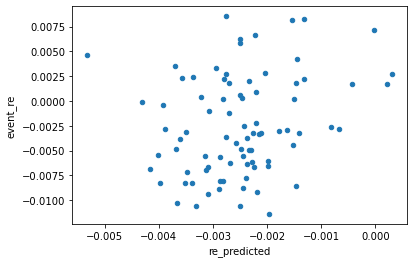

In [57]:
ump_stats.loc[ump_stats['pa']>6000].plot.scatter(x='re_predicted', y='event_re')

<AxesSubplot:xlabel='umpire_h_id'>

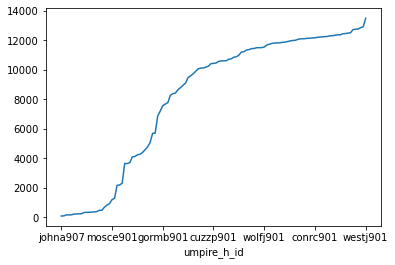

In [58]:
ump_stats.sort_values(by='pa').pa.plot()

In [59]:
ump_stats['re_effect_obs'] = ump_stats['event_re']-ump_stats['re_predicted']
ump_stats.sort_values(by='pa')

,pa,re_predicted,event_re,re_effect_obs
umpire_h_id,,,,
johna907,77,-0.011486,0.000362,0.011848
willl901,87,0.025101,0.102098,0.076997
willr901,153,0.030407,-0.001228,-0.031635
merzd901,153,-0.002430,-0.018358,-0.015928
riggj901,156,0.001606,-0.046080,-0.047686
...,...,...,...,...
hamaa901,12745,-0.003309,-0.010571,-0.007262
hudsm901,12755,-0.002105,-0.003272,-0.001167
mealj901,12851,-0.003486,-0.007120,-0.003634


<AxesSubplot:>

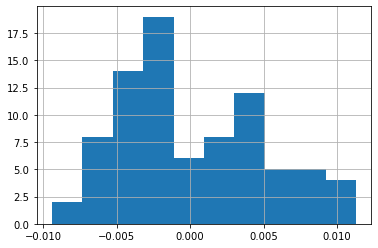

In [60]:
ump_stats.loc[ump_stats['pa']>6000].re_effect_obs.hist()

In [61]:
ump_stats.loc[ump_stats['pa']>6000].sort_values(by='re_effect_obs')

,pa,re_predicted,event_re,re_effect_obs
umpire_h_id,,,,
drecb901,8643,-0.001968,-0.011395,-0.009428
blasc901,11866,-0.002492,-0.010546,-0.008055
hamaa901,12745,-0.003309,-0.010571,-0.007262
fostm901,10448,-0.001474,-0.008593,-0.007120
estam901,12088,-0.002181,-0.009172,-0.006991
...,...,...,...,...
kellj901,8942,-0.002218,0.006613,0.008831
torrc901,10739,-0.001316,0.008322,0.009639
woodt901,6846,-0.001545,0.008135,0.009680
